In [1]:
import os
import openpyxl
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

# Load Data

In [2]:
all_files = []

data_dir = os.path.join("..", "data")
lindt_data_dir = os.path.join(data_dir, "LOREAL")
subfolders = [f.path for f in os.scandir(lindt_data_dir) if f.is_dir()]
for folder in subfolders:
    current_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    all_files.extend(current_files)
print(all_files)

['..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\1Decembre23.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\1Fevrier2024.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\1Janvier24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\1MArs24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\2Decembre23.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\2Fevrier2024.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\2Janvier24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\2Mars24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\3Decembre23.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\3Fevrier24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\3Janvier24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\3Mars24.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\4Decembre23.xlsx', '..\\data\\LOREAL\\LOREALDECEMBREJANVIERFEVRIERMARS\\4Fevrier24.xlsx', '..\\d

In [3]:
df = None

for i, path in enumerate(all_files):
    workbook = openpyxl.load_workbook(path)
    worksheet = workbook["Extraction1"]
    current_date = worksheet["G9"].value.split(" ")[-1]

    current_df = pd.read_excel(path, header=17)

    current_df["File_Index"] = i
    current_df["Date"] = pd.to_datetime(current_date, format='%d/%m/%Y')
    df = pd.concat([df, current_df], ignore_index=True)

df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Year_Month"] = df["Date"].dt.strftime('%Y_%m')

df.head()

,Code Secteur,Libellé Secteur,Code Rayon,Libellé Rayon,Code Groupe de Famille,Libellé Groupe de Famille,Code Famille,Libellé Famille,Code Sous-Famille,Libellé Sous-Famille,...,Quantité vendue *,Type Qté,Stock en quantité,Unnamed: 30,Unnamed: 31,File_Index,Date,Month,Year,Year_Month
0,1,PGC,12,PARFUMERIE HYGIENE,121,HYGIENE TOILETTE,1210,SAVONS DE TOILETTE,3,SAVONS DE MARSEILLE,...,NaN,UVC,10,NaN,1,0,2023-12-09,12,2023,2023_12
1,1,PGC,12,PARFUMERIE HYGIENE,121,HYGIENE TOILETTE,1210,SAVONS DE TOILETTE,3,SAVONS DE MARSEILLE,...,NaN,UVC,10,NaN,1,0,2023-12-09,12,2023,2023_12
2,1,PGC,12,PARFUMERIE HYGIENE,121,HYGIENE TOILETTE,1210,SAVONS DE TOILETTE,5,LIQUIDES,...,3.0,UVC,15,NaN,1,0,2023-12-09,12,2023,2023_12
3,1,PGC,12,PARFUMERIE HYGIENE,121,HYGIENE TOILETTE,1210,SAVONS DE TOILETTE,5,LIQUIDES,...,3.0,UVC,14,NaN,1,0,2023-12-09,12,2023,2023_12
4,1,PGC,12,PARFUMERIE HYGIENE,121,HYGIENE TOILETTE,1210,SAVONS DE TOILETTE,5,LIQUIDES,...,2.0,UVC,8,NaN,1,0,2023-12-09,12,2023,2023_12


## Remove Unnecessary Columns

In [4]:
df = df.drop(df.columns[:15], axis=1)
columns_to_keep = [col for col in df.columns if "Unnamed" not in col]
df = df[columns_to_keep]
columns_to_drop = ["Article Libellé Court", "Type PA", "SRP", "Indicateur PVC", "Type PV Mag", "Indicateur PV Mag", "Type Qté"] # specific columns which we don't need 
df = df.drop(columns=columns_to_drop)
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month
0,3600551126647,SAVON LE NATUREL LAIT UNI,1.50,1.85,1.85,0.2,NaN,10,0,2023-12-09,12,2023,2023_12
1,3600551126654,SAV LE NATUREL CHEVREFEUI,1.50,1.85,1.85,0.2,NaN,10,0,2023-12-09,12,2023,2023_12
2,3760099592394,SAVON LE NAT SAVON 500ML,2.44,2.95,2.95,0.2,3.0,15,0,2023-12-09,12,2023,2023_12
3,3600550300345,LE NAT SAV.LIQ.MIEL 500ML,2.58,3.49,3.49,0.2,3.0,14,0,2023-12-09,12,2023,2023_12
4,3600550300352,LE NAT SAV.LIQ.OLIV 500ML,2.44,3.38,3.38,0.2,2.0,8,0,2023-12-09,12,2023,2023_12


## Clean the values

In [5]:
df = df[~df["PAHT"].isna()]
df = df[~df["PVC"].isna()]
df["Quantité vendue *"] = df["Quantité vendue *"].fillna(0)
df.reset_index(drop=True, inplace=True)
df

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month
0,3600551126647,SAVON LE NATUREL LAIT UNI,1.50,1.85,1.85,0.2,0.0,10,0,2023-12-09,12,2023,2023_12
1,3600551126654,SAV LE NATUREL CHEVREFEUI,1.50,1.85,1.85,0.2,0.0,10,0,2023-12-09,12,2023,2023_12
2,3760099592394,SAVON LE NAT SAVON 500ML,2.44,2.95,2.95,0.2,3.0,15,0,2023-12-09,12,2023,2023_12
3,3600550300345,LE NAT SAV.LIQ.MIEL 500ML,2.58,3.49,3.49,0.2,3.0,14,0,2023-12-09,12,2023,2023_12
4,3600550300352,LE NAT SAV.LIQ.OLIV 500ML,2.44,3.38,3.38,0.2,2.0,8,0,2023-12-09,12,2023,2023_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81930,3600524076139,150ML DEO ATO GREEN M. EX,2.33,3.39,3.39,0.2,3.0,6,51,2023-12-02,12,2023,2023_12
81931,3600550185003,NARTA DEO H.P.ALUN 200ML,2.82,3.65,3.65,0.2,3.0,8,51,2023-12-02,12,2023,2023_12
81932,3600550288544,NARTA DEO ATO H.BACTI.200,2.84,3.58,3.58,0.2,0.0,8,51,2023-12-02,12,2023,2023_12
81933,3600551146133,NARTA HOM DEO AE200 PIERR,3.10,3.19,3.19,0.2,0.0,0,51,2023-12-02,12,2023,2023_12


## Custom calculations

In [6]:
df["Buying Cost without Taxes"] = round(df["PAHT"] * df["Quantité vendue *"], 2)
df["Buying Cost with Taxes"] = round(df["PAHT"] * df["Quantité vendue *"] * (1 + df["TVA en %"]), 2)
df["Revenue"] = round(df["PVC"] * df["Quantité vendue *"], 2)
df["Profit"] = df["Revenue"] - df["Buying Cost with Taxes"]
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,File_Index,Date,Month,Year,Year_Month,Buying Cost without Taxes,Buying Cost with Taxes,Revenue,Profit
0,3600551126647,SAVON LE NATUREL LAIT UNI,1.50,1.85,1.85,0.2,0.0,10,0,2023-12-09,12,2023,2023_12,0.00,0.00,0.00,0.00
1,3600551126654,SAV LE NATUREL CHEVREFEUI,1.50,1.85,1.85,0.2,0.0,10,0,2023-12-09,12,2023,2023_12,0.00,0.00,0.00,0.00
2,3760099592394,SAVON LE NAT SAVON 500ML,2.44,2.95,2.95,0.2,3.0,15,0,2023-12-09,12,2023,2023_12,7.32,8.78,8.85,0.07
3,3600550300345,LE NAT SAV.LIQ.MIEL 500ML,2.58,3.49,3.49,0.2,3.0,14,0,2023-12-09,12,2023,2023_12,7.74,9.29,10.47,1.18
4,3600550300352,LE NAT SAV.LIQ.OLIV 500ML,2.44,3.38,3.38,0.2,2.0,8,0,2023-12-09,12,2023,2023_12,4.88,5.86,6.76,0.90


# Data Analysis

## Total Revenues

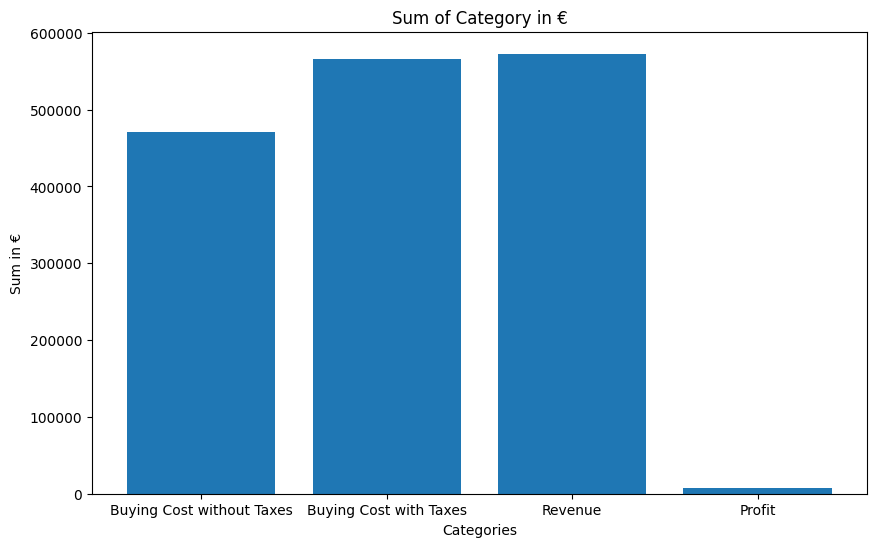

In [7]:
columns = ["Buying Cost without Taxes", "Buying Cost with Taxes", "Revenue", "Profit"]
sum_values = []

for column in columns:
    sum_values.append(round(df[column].sum(),2))

plt.figure(figsize=(10,6))
plt.bar(columns, sum_values)
plt.xlabel("Categories")
plt.ylabel("Sum in €")
plt.title("Sum of Category in €")
plt.show()

## Revenues by Month

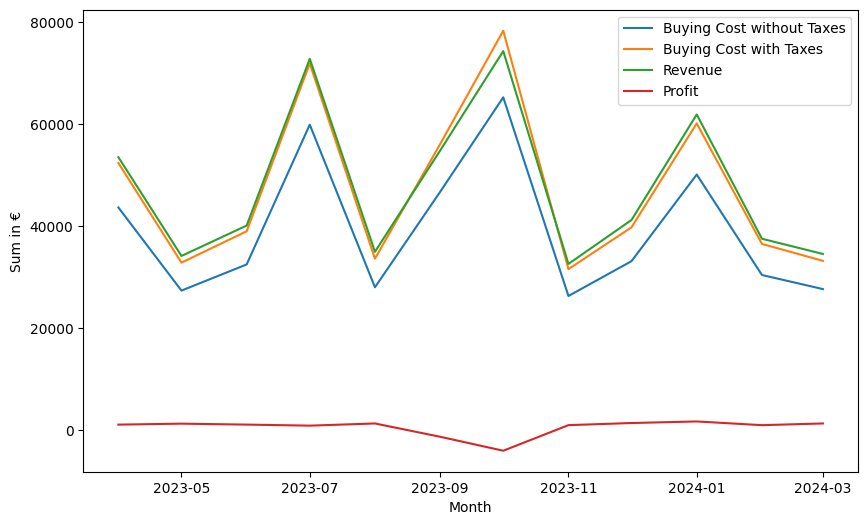

In [8]:
revenue_df = df.copy()
revenue_df['Year_Month'] = pd.to_datetime(revenue_df['Year_Month'], format='%Y_%m')
revenue_df = revenue_df.sort_values(by='Year_Month')

sum_values_by_month = []
for column in columns:
    current_values = revenue_df.groupby("Year_Month")[column].sum()
    sum_values_by_month.append(current_values.round(2).tolist())
months = revenue_df['Year_Month'].unique().tolist()

plt.figure(figsize=(10,6))
for i, values in enumerate(sum_values_by_month, start=0):
    plt.plot(months, values, label=columns[i])
plt.xlabel("Month")
plt.ylabel("Sum in €")
plt.legend()
plt.show()

del revenue_df

## Revenues by Date

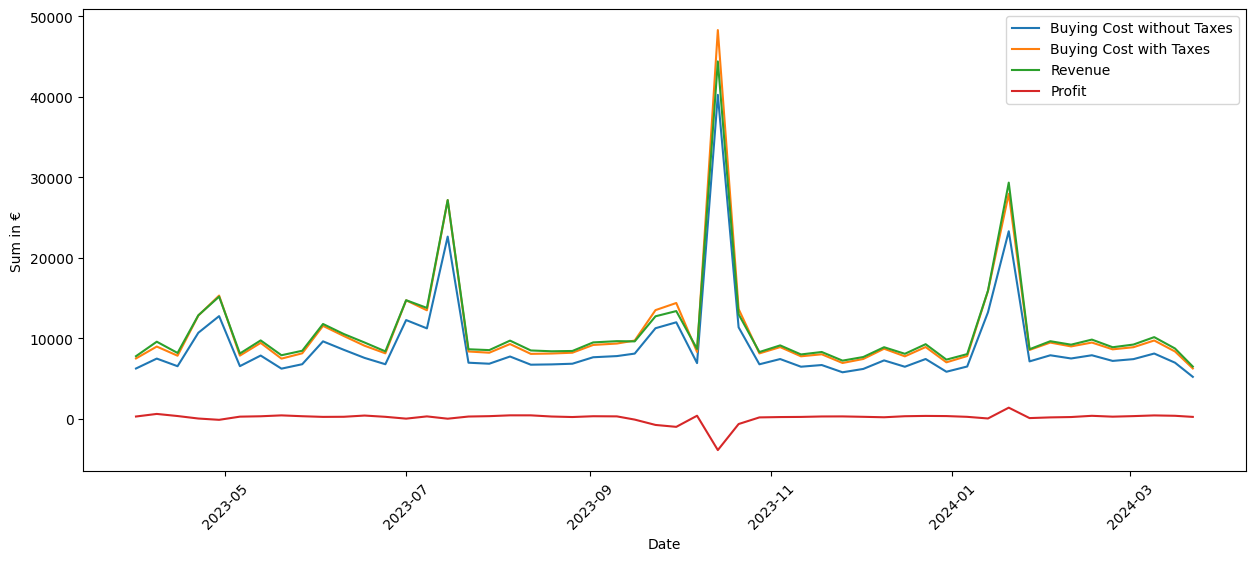

In [9]:
revenue_df = df.copy()
revenue_df = revenue_df.sort_values(by='Date')

sum_values_by_month_week = []
for column in columns:
    current_values = revenue_df.groupby("Date")[column].sum()
    sum_values_by_month_week.append(current_values.round(2).tolist())
month_weeks = revenue_df['Date'].unique().tolist()

plt.figure(figsize=(15,6))
for i, values in enumerate(sum_values_by_month_week, start=0):
    plt.plot(month_weeks, values, label=columns[i])
plt.xlabel("Date")
plt.ylabel("Sum in €")
plt.xticks(rotation=45)
plt.legend()
plt.show()

del revenue_df

## Revenues by Product (best Products)

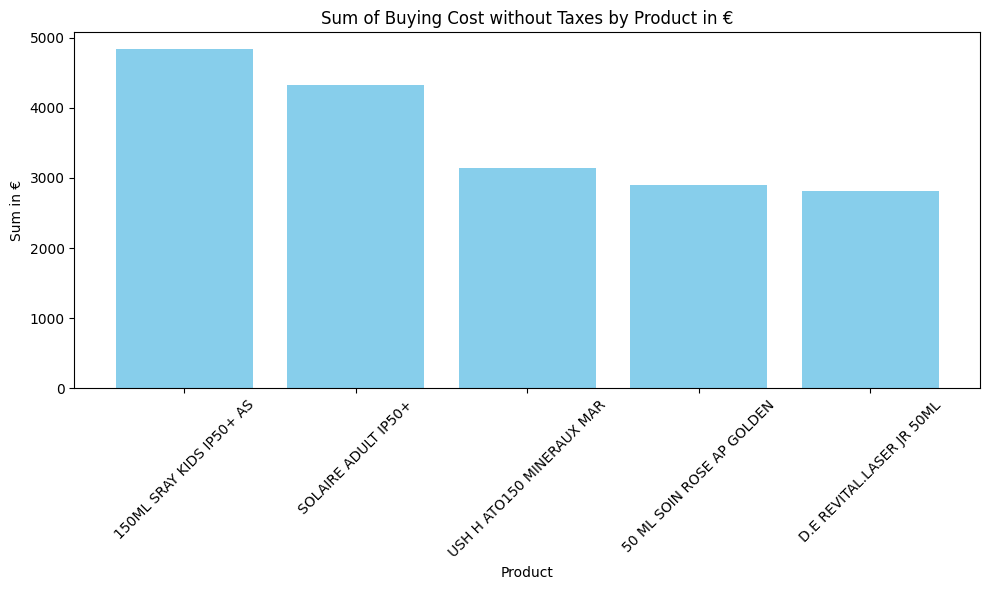

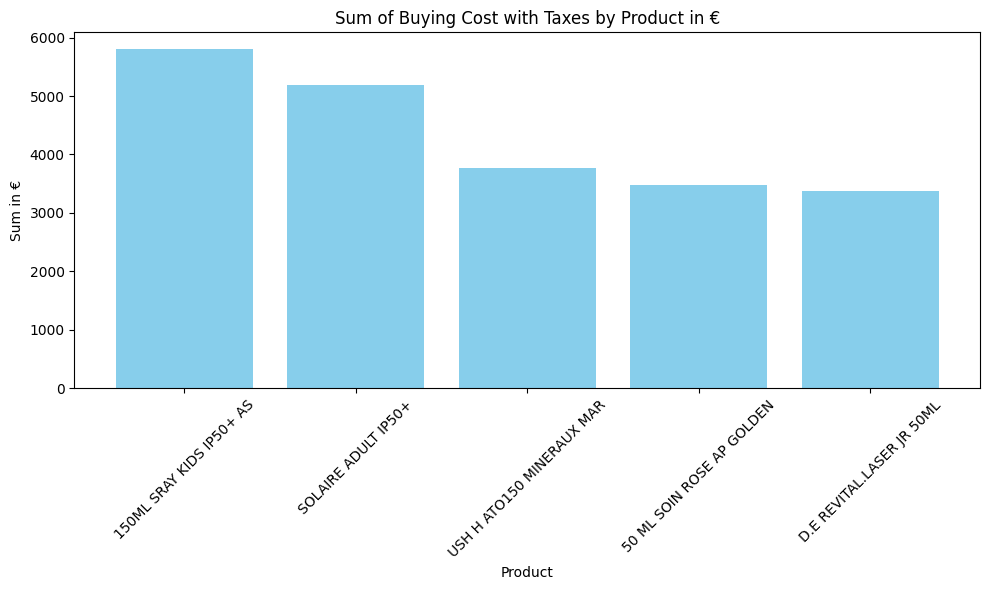

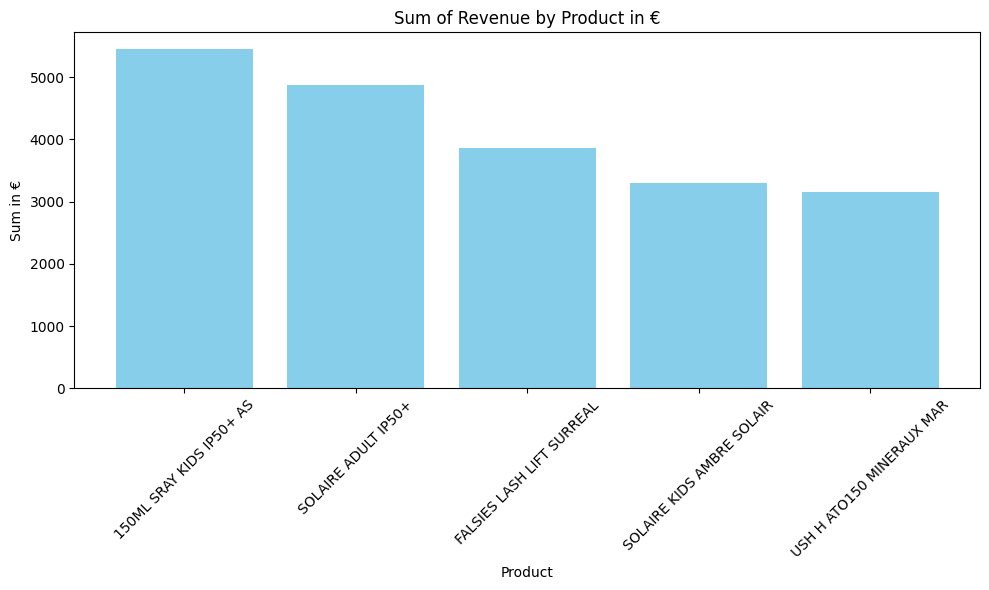

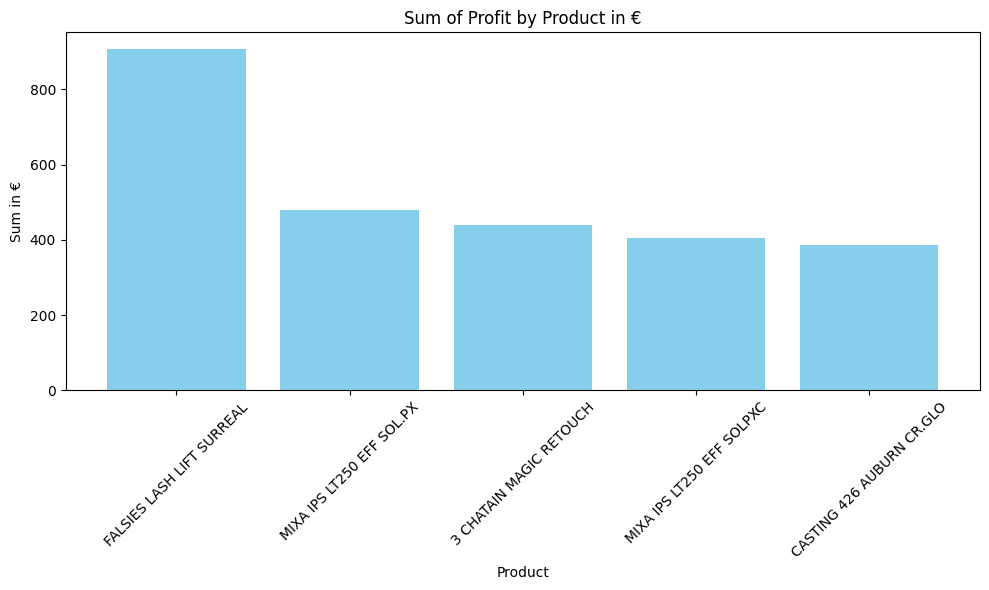

In [10]:
sum_values_by_product = []
for column in columns:
    current_values = df.groupby("Article Libellé Long")[column].sum()
    sum_values_by_product.append(current_values.round(2))
for i, series in enumerate(sum_values_by_product):
    top_5_index = series.nlargest(5).index
    top_5_rows = series.loc[top_5_index]
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(top_5_rows.index, top_5_rows.values, color='skyblue')  # Replace 'column_name' and 'value_column' with your column names
    plt.xlabel('Product')  # Set the label for the x-axis
    plt.ylabel('Sum in €')  # Set the label for the y-axis
    plt.title(f'Sum of {columns[i]} by Product in €')  # Set the title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Machine Learning Model

## Revenue Prediction

In [11]:
revenue_df = df.copy()
revenue_data = df.groupby("Date")["Revenue"].sum()
revenue_df = pd.Series(revenue_data).reset_index().rename(columns={'Date': 'Date', 'Revenue': 'Revenue'})
revenue_df["Revenue"] = round(revenue_df["Revenue"]/7,2)
revenue_df = revenue_df.set_index('Date')

# Resample the DataFrame to fill in missing dates with the next row's revenue value
revenue_df = revenue_df.resample('D').ffill()

# Reset the index to make 'Date' a column again
revenue_df = revenue_df.reset_index()

revenue_df["Year"] = revenue_df["Date"].dt.year
revenue_df["Month"] = revenue_df["Date"].dt.month
revenue_df["Day"] = revenue_df["Date"].dt.day
revenue_df["Day_of_week"] = revenue_df["Date"].dt.day_of_week

revenue_df = revenue_df.dropna()
revenue_df.reset_index(drop=True, inplace=True)

revenue_df.head()

,Date,Revenue,Year,Month,Day,Day_of_week
0,2023-04-01,1110.63,2023,4,1,5
1,2023-04-02,1110.63,2023,4,2,6
2,2023-04-03,1110.63,2023,4,3,0
3,2023-04-04,1110.63,2023,4,4,1
4,2023-04-05,1110.63,2023,4,5,2


In [12]:
X = revenue_df[["Year", "Month", "Day", "Day_of_week"]]
y = revenue_df["Revenue"]

actual_values = []
predicted_values = []
mse_scores = []

tscv = TimeSeriesSplit(n_splits=5)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lgbm_model.fit(X_train, y_train)

    y_pred = lgbm_model.predict(X_test)
    actual_values.extend(y_test.values)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

mean_mse = np.mean(mse_scores)
print("Mean Squarred Error", mean_mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 3
[LightGBM] [Info] Start training from score 1395.606144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

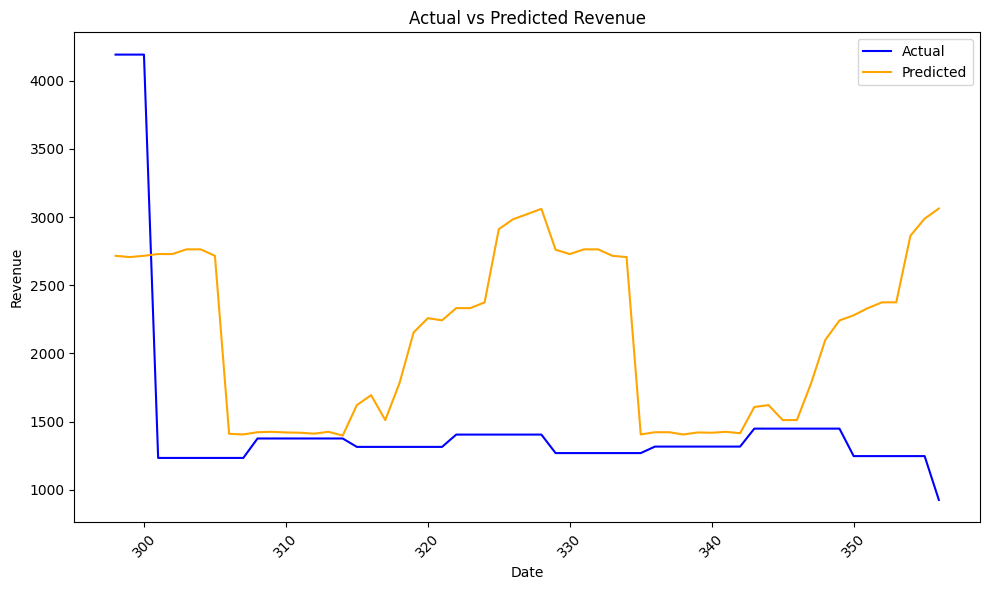

In [13]:
# Plot actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent overlapping labels
plt.show()

In [14]:
future_dates = pd.date_range(start='2024-04-13', end='2024-04-20')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek,
})
future_revenues = lgbm_model.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues
})
print(future_predictions)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
        Date  Predicted_Revenue
0 2024-04-13        1963.941681
1 2024-04-14        2342.782065
2 2024-04-15        2314.349442
3 2024-04-16        2322.365206
4 2024-04-17        2374.801203
5 2024-04-18        2319.968844
6 2024-04-19        2322.398601
7 2024-04-20        2921.754944


In [23]:
with open('lgbm_model_loreal.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

## Revenue Prediction with Mean Revenue of last 21 days

### LGBM

In [15]:
revenue_mean_df = df.copy()
revenue_mean_data = df.groupby("Date")["Revenue"].sum()
revenue_mean_df = pd.Series(revenue_mean_data).reset_index().rename(columns={'Date': 'Date', 'Revenue': 'Revenue'})
revenue_mean_df["Revenue"] = round(revenue_mean_df["Revenue"]/7,2)
revenue_mean_df = revenue_mean_df.set_index('Date')

# Resample the DataFrame to fill in missing dates with the next row's revenue value
revenue_mean_df = revenue_mean_df.resample('D').ffill()

# Reset the index to make 'Date' a column again
revenue_mean_df = revenue_mean_df.reset_index()

revenue_mean_df["Year"] = revenue_mean_df["Date"].dt.year
revenue_mean_df["Month"] = revenue_mean_df["Date"].dt.month
revenue_mean_df["Day"] = revenue_mean_df["Date"].dt.day
revenue_mean_df["Day_of_week"] = revenue_mean_df["Date"].dt.day_of_week
revenue_mean_df['Revenue Mean'] = revenue_mean_df['Revenue'].rolling(21).mean().shift(1)

revenue_mean_df = revenue_mean_df.dropna()
revenue_mean_df.reset_index(drop=True, inplace=True)

revenue_mean_df.head()

,Date,Revenue,Year,Month,Day,Day_of_week,Revenue Mean
0,2023-04-22,1836.21,2023,4,22,5,1215.396667
1,2023-04-23,1836.21,2023,4,23,6,1249.948095
2,2023-04-24,1836.21,2023,4,24,0,1284.499524
3,2023-04-25,1836.21,2023,4,25,1,1319.050952
4,2023-04-26,1836.21,2023,4,26,2,1353.602381


In [16]:
X_mean = revenue_mean_df[["Year", "Month", "Day", "Day_of_week", "Revenue Mean"]]
y_mean = revenue_mean_df["Revenue"]

actual_mean_values = []
predicted_mean_values = []
mse_mean_scores = []

tscv_mean = TimeSeriesSplit(n_splits=5)

lgbm_model_mean = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

for train_idx, test_idx in tscv_mean.split(X_mean):
    X_train, X_test = X_mean.iloc[train_idx], X_mean.iloc[test_idx]
    y_train, y_test = y_mean.iloc[train_idx], y_mean.iloc[test_idx]

    lgbm_model_mean.fit(X_train, y_train)

    y_pred = lgbm_model_mean.predict(X_test)
    actual_mean_values.extend(y_test.values)
    predicted_mean_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mse_mean_scores.append(mse)

mean_mse = np.mean(mse_mean_scores)
print("Mean Squarred Error", mean_mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 3
[LightGBM] [Info] Start training from score 1509.210007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

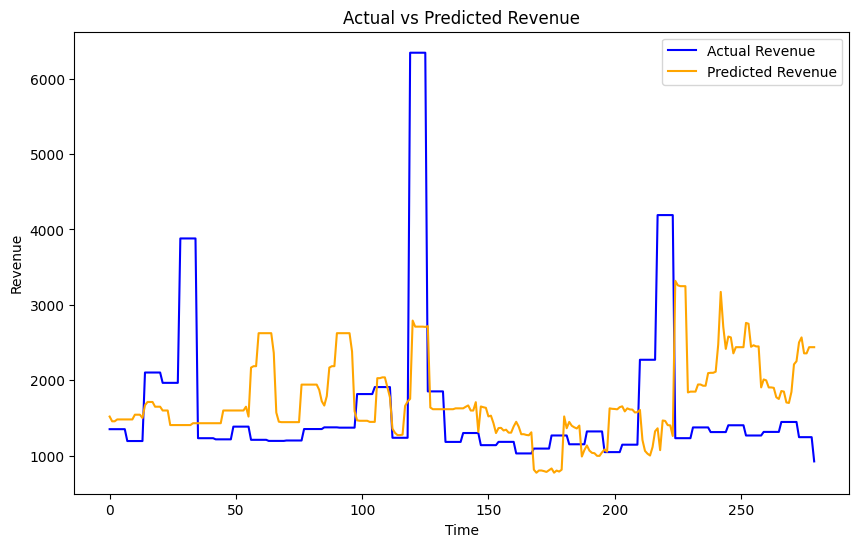

In [17]:
# Plot actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.plot(actual_mean_values, label='Actual Revenue', color='blue')
plt.plot(predicted_mean_values, label='Predicted Revenue', color='orange')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

In [18]:
future_dates = pd.date_range(start='2024-04-13', end='2024-04-20')  # Example future dates
future_features = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Day_of_week': future_dates.dayofweek,
    "Revenue Mean": [500 for i in range(len(future_dates))]
})
future_revenues = lgbm_model_mean.predict(future_features)

# Display predicted revenues for future dates
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Revenue': future_revenues
})
print(future_predictions)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
        Date  Predicted_Revenue
0 2024-04-13        1704.624925
1 2024-04-14        2268.530274
2 2024-04-15        2112.191893
3 2024-04-16        2112.191893
4 2024-04-17        2190.444047
5 2024-04-18        2216.899162
6 2024-04-19        2216.899162
7 2024-04-20        2430.792895


In [22]:
with open('lgbm_model_mean_loreal.pkl', 'wb') as f:
    pickle.dump(lgbm_model_mean, f)